In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
!pip install -q paddlepaddle

In [ ]:
# 여기까지 실행 후 런타임 재시작!!
!pip install paddleocr

In [ ]:
# libssl 설치
!wget http://archive.ubuntu.com/ubuntu/pool/main/o/openssl/libssl1.1_1.1.0g-2ubuntu4_amd64.deb
!sudo dpkg -i libssl1.1_1.1.0g-2ubuntu4_amd64.deb

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/NanumSquareNeo-Variable.ttf

# 패키지 import 및 함수

In [ ]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.cluster import DBSCAN
import csv
import os
import pandas as pd

In [ ]:
# OCR 객체 생성
ocr = PaddleOCR(lang = 'korean')

In [ ]:
# 이미지를 종류별로 생성
def more_images(img):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColot(img, cv2.COLOT_BGR2GRAY)

    return rgb_img, gray_img

In [ ]:
# 여기서 img는 PIL이 아니라 cv2.imread로 불러온 img를 사용할 것
def scale_line(img, line):
    # txt 파일의 중심좌표 (x, y)와 width, height 값으로 나누기
    line = line.replace('\n', '')
    txt_lst = line.split(' ')
    corrs = [float(corr) for corr in txt_lst if '.' in corr]
    x, y, w, h = corrs

    # 이미지 크기에 맞게 좌표를 수정 (좌표는 가로와 세로 길이를 1로 놓았기 때문)
    x = int(x * img.shape[0])
    y = int(y * img.shape[1])
    w = int(w * img.shape[0])
    h = int(h * img.shape[1])

    return x, y, w, h

In [ ]:
def image_scale(img, line):
    # 일반적인 현수막의 가로, 세로 크기
    sc_w, sc_h = 2000, 360

    # 중심좌표 x, y와 가로길이 w, 세로길이 h
    x, y, w, h = scale_line(img, line)

    # 이미지를 주어진 x, y, w, h 값을 바탕으로 자르고 조정하기
    srcQuad = np.array([[x - w/2, y - h/2], [x + w/2, y - h/2], [x + w/2, y + h/2], [x - w/2, y + h/2]], np.float32)
    dstQuad = np.array([[1,1], [sc_w-1, 1], [sc_w-1, sc_h-1], [1, sc_h-1]], np.float32)
    pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
    dst = cv2.warpPerspective(img, pers, (sc_w, sc_h))

    return dst

In [ ]:
def get_words(result):
    corrs = [temp[0] for temp in result[0]]  # 좌표들을 corrs에 저장
    texts = [temp[1][0] for temp in result[0]]  # 글자들을 texts에 저장
    scores = [temp[1][1] for temp in result[0]]  # 정확도를 scores에 저장

    return corrs, texts, scores

In [ ]:
# 어떤 글자들을 인식했는지 표시해주는 함수
def show_ocr(result, img_path, ocr):
    img = cv2.imread(img_path)
    corrs, texts, scores = get_words(result)
    result_simple = draw_ocr(image = img, boxes = corrs)
    result_details = draw_ocr(image = img, boxes = corrs, txts = texts, scores = scores, font_path = 'NanumSquareNeo-Variable.ttf')

    return result_simple, result_details

In [ ]:
def cluster_by_lines(corrs, texts):
    cor_texts = []
    for i in range(len(corrs)):
        cor_texts.append([corrs[i][0], texts[i]])

    cor_texts = sorted(cor_texts, key=lambda x:x[0][1])

    text_result = []
    current_group = [cor_texts[0]]

    for i in range(1, len(cor_texts)):
        if abs(cor_texts[i-1][0][1] - cor_texts[i][0][1]) < 15:
            current_group.append(cor_texts[i])
        else:
            text_result.append(current_group)
            current_group = [cor_texts[i]]

    text_result.append(current_group)

    sorted_bundle = []
    for texts in text_result:
        texts = sorted(texts, key=lambda x:x[0][0])
        sorted_bundle.append(texts)

    lines = []
    for bundle in sorted_bundle:
        texts_only = []
        for words in bundle:
            texts_only.append(words[1])

        lines.append(' '.join(texts_only))

    return lines

In [ ]:
# 원본 사진 이름과 내용을 리스트로 저장
def make_df(img_path, lines):
    line = ' '.join(lines)
    banner = [img_path, line]
    return banner

In [ ]:
# 리스트를 csv 파일로 저장. 만약 파일이 없다면 생성
def to_csv(banner):
    if os.path.isfile('banner text.csv'):
        with open('banner text.csv', 'a', newline = '') as f:
            writer = csv.writer(f)
            writer.writerow(banner)
    else:
        with open('banner text.csv', 'w', newline = '') as f:
            writer = csv.writer(f)
            writer.writerow(banner)

In [36]:
# 스케일링되지 않은 이미지의 경우
def unscaled_one_click(img_path, txt_path):
    img = cv2.imread(img_path)
    txt = open(txt_path, 'r')
    txt_line = txt.readline()
    txt.close

    dst = image_scale(img, txt_line)
    scaled_path = 'scaled_' + img_path
    cv2.imwrite(scaled_path, dst)
    result = ocr.ocr(img = scaled_path, cls = False)

    result_simple, result_details = show_ocr(result, scaled_path, ocr)

    corrs, texts, _ = get_words(result)
    contents = cluster_by_lines(corrs, texts)

    banner = make_df(img_path, contents)
    to_csv(banner)

    return result_simple, result_details, contents

In [37]:
# 스케일링된 이미지의 경우
def scaled_one_click(img_path, scaled_path):
    result = ocr.ocr(img = scaled_path, cls = False)
    result_simple, result_details = show_ocr(result, scaled_path, ocr)

    corrs, texts, _ = get_words(result)
    contents = cluster_by_lines(corrs, texts)

    banner = make_df(img_path, contents)
    to_csv(banner)

    return result_simple, result_details, contents

# 작업 1회차

[2023/08/14 07:57:43] ppocr DEBUG: dt_boxes num : 19, elapse : 0.7893161773681641
[2023/08/14 07:57:53] ppocr DEBUG: rec_res num  : 19, elapse : 9.487287998199463
['필라+PT 교정', 'NAVER 편디르치', '여성진312년 입너다', '바디코치 예쁜 비울교정 소 PT 031-274-7497', '프라0N 여싱전드']


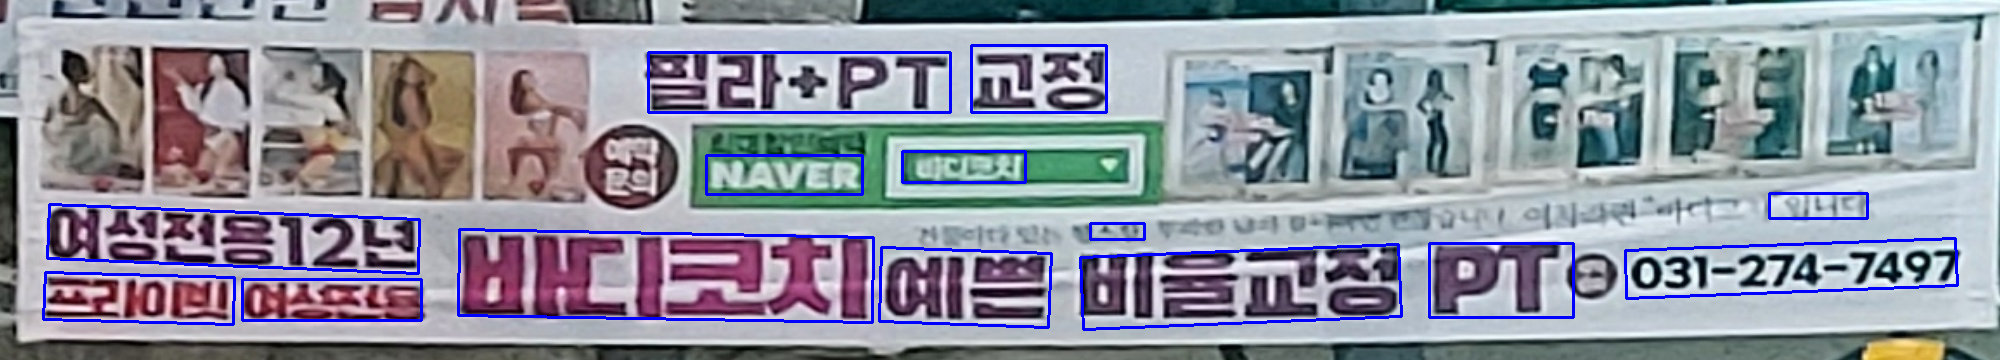

In [38]:
result_simple, result_details, contents = unscaled_one_click('KakaoTalk_20230807_162906464.jpg', 'KakaoTalk_20230807_162906464.txt')
print(contents)
cv2_imshow(result_simple)

[2023/08/14 07:57:54] ppocr DEBUG: dt_boxes num : 10, elapse : 0.1843123435974121
[2023/08/14 07:58:00] ppocr DEBUG: rec_res num  : 10, elapse : 5.990261793136597
['용인 채취행위금지', '야생조류포획및알', '철말이하발 저 수있습니다', '필한료에 의기가이하지면또', '야생동물보및관리에']


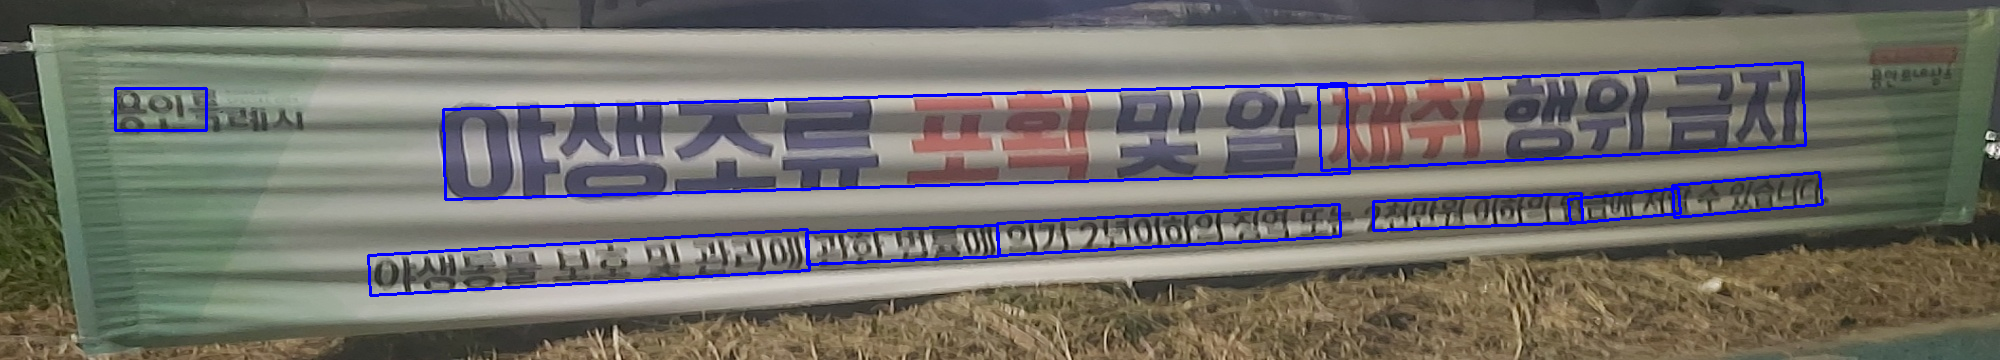

In [39]:
result_simple, result_details, contents = unscaled_one_click('20230803_202406.jpg', '20230803_202406.txt')
print(contents)
cv2_imshow(result_simple)

[2023/08/14 07:58:01] ppocr DEBUG: dt_boxes num : 14, elapse : 0.3189265727996826
[2023/08/14 07:58:07] ppocr DEBUG: rec_res num  : 14, elapse : 6.684591770172119
['머래를그리는강난 꿈이모이는도시 2023 주민등록 사실조사 실시 강남구 분G', '비대면 조사정부24 2023724~ 8 20 방문조사 20238 21~ 10 10']


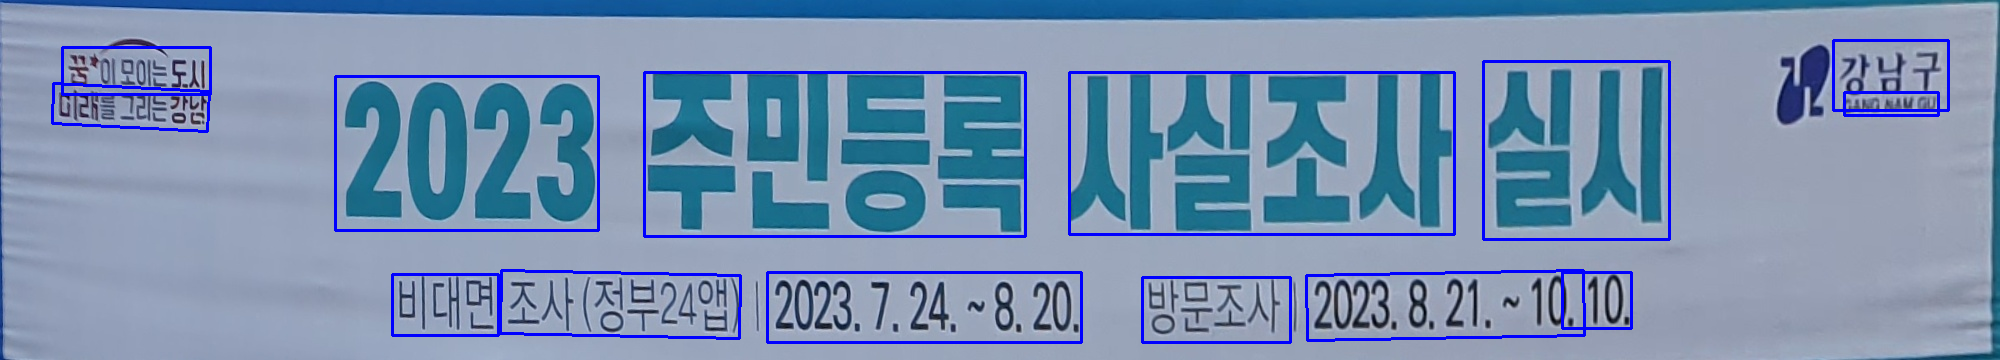

In [40]:
result_simple, result_details, contents = scaled_one_click('20230804_074159.jpg', 'scaled_img.jpg')
print(contents)
cv2_imshow(result_simple)

[2023/08/14 07:58:08] ppocr DEBUG: dt_boxes num : 9, elapse : 0.27478599548339844
[2023/08/14 07:58:13] ppocr DEBUG: rec_res num  : 9, elapse : 4.967121839523315
['민생회복 경제도약 서민보호 더불어민주당', '합시다!35조 민생주경', '강남병 지역위원회', '02-3423-8067/제작070-7758-9620/기간2382~23816']


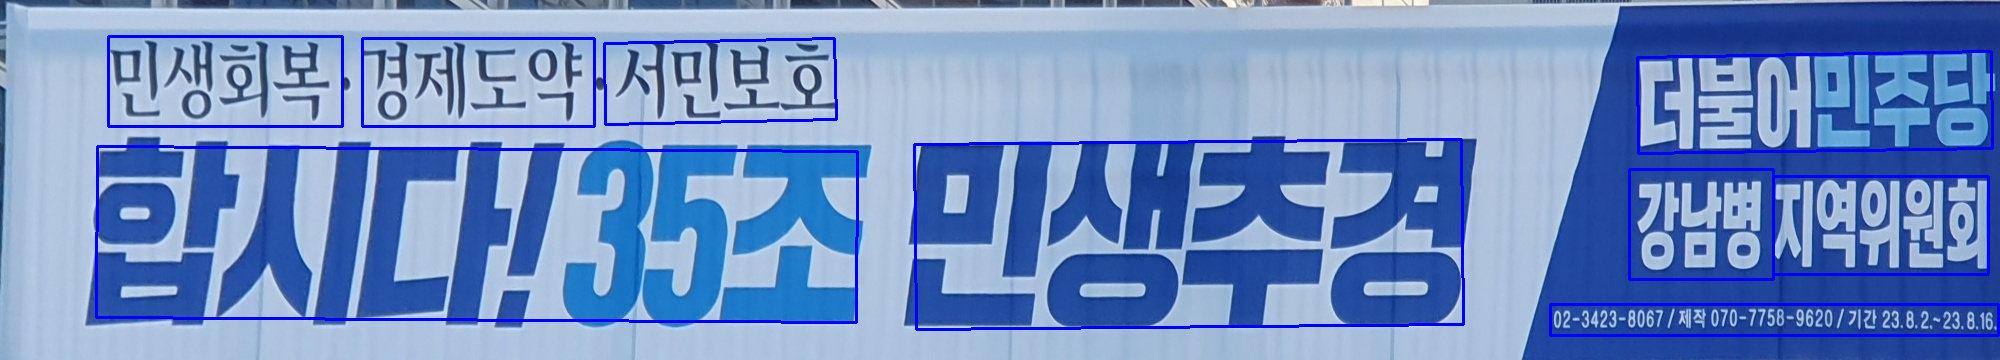

In [41]:
result_simple, result_details, contents = scaled_one_click('20230803_184611.jpg', 'scaled_img2.jpg')
print(contents)
cv2_imshow(result_simple)

In [42]:
df = pd.read_csv('banner text.csv', names=['name', 'contents'])
df

,name,contents
0,KakaoTalk_20230807_162906464.jpg,필라+PT 교정 NAVER 편디르치 여성진312년 입너다 바디코치 예쁜 비울교정 소...
1,20230803_202406.jpg,채취행위금지 야생조류포획및알 철말무이하음발 컴저 할수있습니다 생동물보함민괴리에
2,20230803_202406.jpg,용인 채취행위금지 야생조류포획및알 철말이하발 저 수있습니다 필한료에 의기가이하지면또...
3,20230804_074159.jpg,머래를그리는강난 꿈이모이는도시 2023 주민등록 사실조사 실시 강남구 분G 비대면 ...
4,20230803_184611.jpg,민생회복 경제도약 서민보호 더불어민주당 합시다!35조 민생주경 강남병 지역위원회 0...
5,20230804_074159.jpg,머래를그리는강난 꿈이모이는도시 2023 주민등록 사실조사 실시 강남구 분G 비대면 ...
6,20230803_184611.jpg,민생회복 경제도약 서민보호 더불어민주당 합시다!35조 민생주경 강남병 지역위원회 0...
7,KakaoTalk_20230807_162906464.jpg,필라+PT 교정 NAVER 편디르치 여성진312년 입너다 바디코치 예쁜 비울교정 소...
8,20230803_202406.jpg,용인 채취행위금지 야생조류포획및알 철말이하발 저 수있습니다 필한료에 의기가이하지면또...
9,20230804_074159.jpg,머래를그리는강난 꿈이모이는도시 2023 주민등록 사실조사 실시 강남구 분G 비대면 ...
